In [1]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import scipy
import iris
import iris.pandas
from iris.experimental import stratify
from iris.analysis import trajectory
import warnings
warnings.filterwarnings('ignore', module='iris')
from pathlib import Path
import dateutil.parser
from datetime import datetime, timedelta
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Scientific parameters
M_air = 28.97 # molar mass of dry air [kg]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12 # Ethane_WAS
coeff_c3h8 = (M_air/44.0956)*1e12 # Propane_WAS
coeff_nc4h10 = (M_air/58.1222)*1e12 # n-Butane_WAS
coeff_ic4h10 = (M_air/58.1222)*1e12 # i-Butane_WAS
coeff_nc5h12 = (M_air/72.1488)*1e12 # n-Pentane_WAS
coeff_ic5h12 = (M_air/72.1488)*1e12 # i-Pentane_WAS
coeff_meono2 = (M_air/77.0394)*1e12 # MeONO2_WAS
coeff_sbuono2 = (M_air/119.1192)*1e12 # 2-BuONO2_WAS or sBuONO2
coeff_n2peono2 = (M_air/133.1457)*1e12 # 2-PenONO2_WAS or n2PeONO2 or nPeBONO2
coeff_n3peono2 = (M_air/133.1457)*1e12 # 3-PenONO2_WAS or n3PeONO2 or nPeCONO2
coeff_ipeono2 = (M_air/133.1457)*1e12 # 3-Methyl-2-BuONO2_WAS or iPeONO2 or iPeBONO2
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
savefig = True
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [2]:
path_to_atom = Path('../../external_data/ATom/nc/data')
# Select flights
flist_atom_flights = ['MER-WAS_DC8_20170218_R8.nc', 'MER-WAS_DC8_20170219_R7.nc', 'MER-WAS_DC8_20170221_R8.nc']
fpaths_atom_flights = [path_to_atom / i for i in flist_atom_flights]
# Read ATom data
atom_dsinf = xr.open_mfdataset(fpaths_atom_flights, decode_times=True)
atom_dsmms = xr.open_mfdataset(fpaths_atom_flights, group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(fpaths_atom_flights, group='WAS', decode_cf=True)

In [3]:
# Read precalculated UKCA trajectories
ukca_run_name = 'ba897'
compared_common_id = '170218_170221_1702_merge_zlvs'
path_to_prcd = Path('../processed') / ukca_run_name
traj_nc4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_nc4h10.nc')
traj_ic4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ic4h10.nc')
traj_nc5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_nc5h12.nc')
traj_ic5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ic5h12.nc')
traj_sbuono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_sbuono2.nc')
traj_n2peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_n2peono2.nc')
traj_n3peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_n3peono2.nc')
traj_ipeono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ipeono2.nc')

In [4]:
# Path to figures
path_to_figs = Path('../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist
print(compared_common_id)

170218_170221_1702_merge_zlvs


#### Time series of concentrations along flight track

In [5]:
# Extract datetimes from ATom data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
# Time series and cross section plotting parameters
if compared_common_id == '170218_170221_1702_merge_zlvs':
    flght_separators = [149, 308] # manually select indices of flight start times in a merge
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 50) # manually choose frequency of datetimes for xticklabels
slct_time_lbls = [i.strftime('%H:%M\n%d-%m-%Y') for i in atom_dsinf.time.values[slct_time_inds].astype('<M8[us]').astype(datetime)]
print(slct_time_inds, atom_dsinf.time.shape)

[  0  50 100 150 200 250 300 350 400] (435,)


#### RONO2/RH time series along flight track

In [6]:
# Mask UKCA 3D trajectories of RONO2/RH ratios that are higher than 1 and calculate the sum of n-pentyl nitrates
traj_sbuono2_nc4h10 = traj_sbuono2.data/traj_nc4h10.data
for i, ii in enumerate(traj_sbuono2_nc4h10):
    if ii > 1.:
        traj_sbuono2_nc4h10[i] = np.nan
traj_npeono2_nc5h12 = (traj_n2peono2.data+traj_n3peono2.data)/traj_nc5h12.data
for i, ii in enumerate(traj_npeono2_nc5h12):
    if ii > 1.:
        traj_npeono2_nc5h12[i] = np.nan
traj_ipeono2_ic5h12 = traj_ipeono2.data/traj_ic5h12.data
for i, ii in enumerate(traj_ipeono2_ic5h12):
    if ii > 1.:
        traj_ipeono2_ic5h12[i] = np.nan

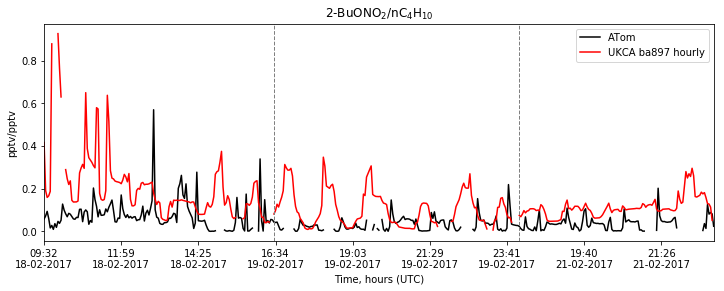

In [7]:
# Plot time series of RONO2/RH ratio along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['2-BuONO2_WAS']/atom_dswas['n-Butane_WAS'], color='k')
ax.plot(traj_sbuono2_nc4h10, color='r')
# common
ax.set_title(f'{str_sbuono2}/{str_nc4h10}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_RH_C4s.png', bbox_inches='tight')

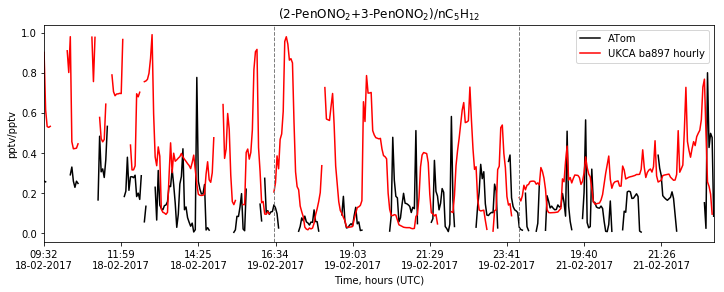

In [8]:
# Plot time series of RONO2/RH ratio along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot((atom_dswas['2-PenONO2_WAS']+atom_dswas['3-PenONO2_WAS'])/atom_dswas['n-Pentane_WAS'], color='k')
ax.plot(traj_npeono2_nc5h12, color='r')
# common
ax.set_title(f'({str_n2peono2}+{str_n3peono2})/{str_nc5h12}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_RH_C5n.png', bbox_inches='tight')

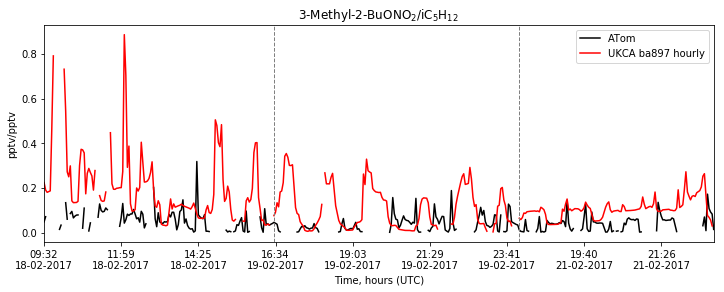

In [9]:
# Plot time series of RONO2/RH ratio along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['3-Methyl-2-BuONO2_WAS']/atom_dswas['i-Pentane_WAS'], color='k')
ax.plot(traj_ipeono2_ic5h12, color='r')
# common
ax.set_title(f'{str_ipeono2}/{str_ic5h12}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv/pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} hourly'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_RH_C5i.png', bbox_inches='tight')

#### Cross section along flight track

In [10]:
# Read precalculated UKCA 2D trajectories
crsc_nc4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc4h10.nc')
crsc_ic4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic4h10.nc')
crsc_nc5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc5h12.nc')
crsc_ic5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic5h12.nc')
crsc_sbuono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_sbuono2.nc')
crsc_n2peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n2peono2.nc')
crsc_n3peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n3peono2.nc')
crsc_ipeono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ipeono2.nc')

In [11]:
# Convert xarray dataset with observational data to pandas dataframe
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [12]:
# Find max between maxima and max between minima in ATom and model cross section data for plotting a cross section with two colormaps
cs_nc4h10_max = max(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_max = max(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_max = max(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_max = max(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_sbuono2_max = max(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_max = max(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_max = max(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_max = max(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

cs_nc4h10_min = min(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_min = min(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_min = min(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_min = min(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_sbuono2_min = min(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_min = min(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_min = min(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_min = min(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

In [13]:
# Cross section plotting parameters
mrgd_time_inds = np.arange(0,atom_dsinf.time.values.shape[0],1) # merged time indices
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
# Merge two colormaps: color concentrations present in obs and model using one colormap and obs higher than model using another colormap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
colors_low = plt.cm.Blues(np.linspace(0,1,128))
colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
colors_stack = np.vstack((colors_low, colors_high))
mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)
cs_pc_kwargs = dict(cmap=mrgd_cmap, vmin=0) # model data pcolormesh options
cs_sc_kwargs = dict(cmap=mrgd_cmap, vmin=0, edgecolors='k', linewidth=0.2) # obs data scatter options

#### RONO2/RH cross section along flight track

In [14]:
# Calculate RONO2/RH ratios and add up n-pentyl nitrates
atom_sbuono2_nc4h10 = atom_sbuono2.squeeze()/atom_nc4h10.squeeze()
atom_npeono2_nc5h12 = (atom_n2peono2.squeeze()+atom_n3peono2.squeeze())/atom_nc5h12.squeeze()
atom_ipeono2_ic5h12 = atom_ipeono2.squeeze()/atom_ic5h12.squeeze()

crsc_sbuono2_nc4h10 = crsc_sbuono2.data/crsc_nc4h10.data
crsc_npeono2_nc5h12 = (crsc_n2peono2.data+crsc_n3peono2.data)/crsc_nc5h12.data
crsc_ipeono2_ic5h12 = crsc_ipeono2.data/crsc_ic5h12.data

In [15]:
# RONO2/RH cross section plotting parameters
cs_sbuono2_nc4h10_max = max(np.nanmax(atom_sbuono2_nc4h10), np.nanmax(traj_sbuono2_nc4h10)) # or 1
cs_npeono2_nc5h12_max = max(np.nanmax(atom_npeono2_nc5h12), np.nanmax(traj_npeono2_nc5h12)) # or 1
cs_ipeono2_ic5h12_max = max(np.nanmax(atom_ipeono2_ic5h12), np.nanmax(traj_ipeono2_ic5h12)) # or 1

cs_pc_rono2_rh_kwargs = dict(cmap='Blues', vmin=0)
cs_sc_rono2_rh_kwargs = dict(cmap='Blues', vmin=0,  edgecolors='k', linewidth=0.2)

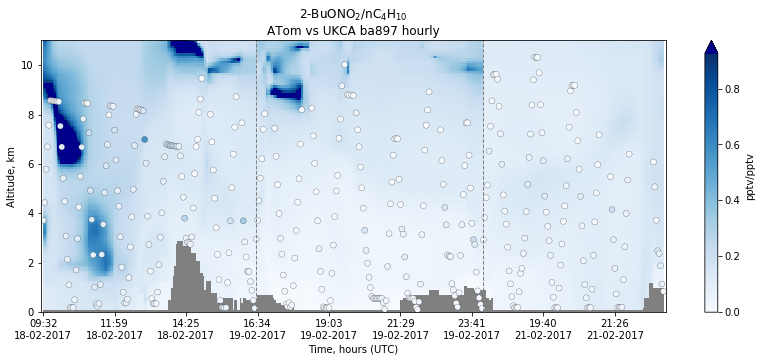

In [16]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_sbuono2.coord('altitude').points, crsc_sbuono2_nc4h10, vmax=cs_sbuono2_nc4h10_max, 
                   **cs_pc_rono2_rh_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_sbuono2_nc4h10, vmax=cs_sbuono2_nc4h10_max, **cs_sc_rono2_rh_kwargs)
cb0 = fig.colorbar(p0, label='pptv/pptv', extend='max')
cb0.cmap.set_over('darkblue')
p0.cmap.set_bad('grey', alpha=1)
# common
ax.set_title(f'{str_sbuono2}/{str_nc4h10}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,11000)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_RH_C4s.png', bbox_inches='tight')

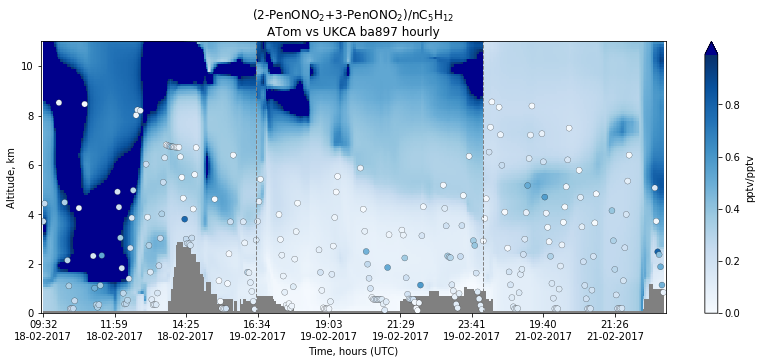

In [17]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_sbuono2.coord('altitude').points, crsc_npeono2_nc5h12, vmax=cs_npeono2_nc5h12_max, 
                   **cs_pc_rono2_rh_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_npeono2_nc5h12, vmax=cs_npeono2_nc5h12_max, **cs_sc_rono2_rh_kwargs)
cb0 = fig.colorbar(p0, label='pptv/pptv', extend='max')
cb0.cmap.set_over('darkblue')
p0.cmap.set_bad('grey', alpha=1)
# common
ax.set_title(f'({str_n2peono2}+{str_n3peono2})/{str_nc5h12}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,11000)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_RH_C5n.png', bbox_inches='tight')

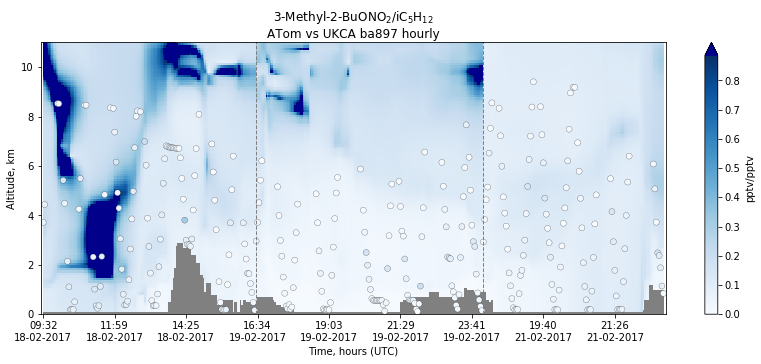

In [18]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_sbuono2.coord('altitude').points, crsc_ipeono2_ic5h12, vmax=cs_ipeono2_ic5h12_max, 
                   **cs_pc_rono2_rh_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_ipeono2_ic5h12, vmax=cs_ipeono2_ic5h12_max, **cs_sc_rono2_rh_kwargs)
cb0 = fig.colorbar(p0, label='pptv/pptv', extend='max')
cb0.cmap.set_over('darkblue')
p0.cmap.set_bad('grey', alpha=1)
# common
ax.set_title(f'{str_ipeono2}/{str_ic5h12}\nATom vs UKCA {ukca_run_name} hourly')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,11000)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_RH_C5i.png', bbox_inches='tight')

#### Scatter plot data along flight track

In [20]:
# Find max concentration between observational and model trajectory data
sct_max_nc4h10 = max(np.nanmax(atom_nc4h10.values), np.nanmax(traj_nc4h10.data))
sct_max_ic4h10 = max(np.nanmax(atom_ic4h10.values), np.nanmax(traj_ic4h10.data))
sct_max_nc5h12 = max(np.nanmax(atom_nc5h12.values), np.nanmax(traj_nc5h12.data))
sct_max_ic5h12 = max(np.nanmax(atom_ic5h12.values), np.nanmax(traj_ic5h12.data))
sct_max_sbuono2 = max(np.nanmax(atom_sbuono2.values), np.nanmax(traj_sbuono2.data))
sct_max_n2peono2 = max(np.nanmax(atom_n2peono2.values), np.nanmax(traj_n2peono2.data))
sct_max_n3peono2 = max(np.nanmax(atom_n3peono2.values), np.nanmax(traj_n3peono2.data))
sct_max_ipeono2 = max(np.nanmax(atom_ipeono2.values), np.nanmax(traj_ipeono2.data))

#### Scatter plot RONO2/RH along flight track
Remember that RONO2/RH values higher than 1 were filtered from UKCA 3D trajectories in the cells above.

In [21]:
# Remove NaNs from ATom and UKCA 3D trajectories in order pass these data into a linear regression model
atom_nonan_sbuono2_nc4h10 = atom_sbuono2_nc4h10[~np.isnan(atom_sbuono2_nc4h10) & ~np.isnan(traj_sbuono2_nc4h10)]
atom_nonan_npeono2_nc5h12 = atom_npeono2_nc5h12[~np.isnan(atom_npeono2_nc5h12) & ~np.isnan(traj_npeono2_nc5h12)]
atom_nonan_ipeono2_ic5h12 = atom_ipeono2_ic5h12[~np.isnan(atom_ipeono2_ic5h12) & ~np.isnan(traj_ipeono2_ic5h12)]

traj_nonnan_sbuono2_nc4h10 = traj_sbuono2_nc4h10[~np.isnan(atom_sbuono2_nc4h10) & ~np.isnan(traj_sbuono2_nc4h10)]
traj_nonnan_npeono2_nc5h12 = traj_npeono2_nc5h12[~np.isnan(atom_npeono2_nc5h12) & ~np.isnan(traj_npeono2_nc5h12)]
traj_nonnan_ipeono2_ic5h12 = traj_ipeono2_ic5h12[~np.isnan(atom_ipeono2_ic5h12) & ~np.isnan(traj_ipeono2_ic5h12)]

In [22]:
# Calculate a linear least-squares regression
slope_c4s, intrcpt_c4s, r_val_c4s, p_val_c4s, std_err_c4s = scipy.stats.linregress(atom_nonan_sbuono2_nc4h10, traj_nonnan_sbuono2_nc4h10)
slope_c5n, intrcpt_c5n, r_val_c5n, p_val_c5n, std_err_c5n = scipy.stats.linregress(atom_nonan_npeono2_nc5h12, traj_nonnan_npeono2_nc5h12)
slope_c5i, intrcpt_c5i, r_val_c5i, p_val_c5i, std_err_c5i = scipy.stats.linregress(atom_nonan_ipeono2_ic5h12, traj_nonnan_ipeono2_ic5h12)
# Find max points of linear regression along x and y axis
lreg_c4s_x_max = max(atom_nonan_sbuono2_nc4h10.max(), traj_nonnan_sbuono2_nc4h10.max())
lreg_c5n_x_max = max(atom_nonan_npeono2_nc5h12.max(), traj_nonnan_npeono2_nc5h12.max())
lreg_c5i_x_max = max(atom_nonan_ipeono2_ic5h12.max(), traj_nonnan_ipeono2_ic5h12.max())
lreg_c4s_y_max = lreg_c4s_x_max*slope_c4s + intrcpt_c4s
lreg_c5n_y_max = lreg_c5n_x_max*slope_c5n + intrcpt_c5n
lreg_c5i_y_max = lreg_c5i_x_max*slope_c5i + intrcpt_c5i
# Take slope error into account
lreg_c4s_y_max_minus_std_err = lreg_c4s_x_max*(slope_c4s-std_err_c4s) + intrcpt_c4s
lreg_c5n_y_max_minus_std_err = lreg_c5n_x_max*(slope_c5n-std_err_c5n) + intrcpt_c5n
lreg_c5i_y_max_minus_std_err = lreg_c5i_x_max*(slope_c5i-std_err_c5i) + intrcpt_c5i
lreg_c4s_y_max_plus_std_err = lreg_c4s_x_max*(slope_c4s+std_err_c4s) + intrcpt_c4s
lreg_c5n_y_max_plus_std_err = lreg_c5n_x_max*(slope_c5n+std_err_c5n) + intrcpt_c5n
lreg_c5i_y_max_plus_std_err = lreg_c5i_x_max*(slope_c5i+std_err_c5i) + intrcpt_c5i

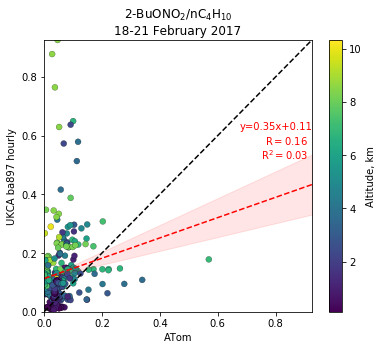

In [23]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_sbuono2_nc4h10, traj_sbuono2_nc4h10.data, c=atom_dsmms.G_ALT, edgecolors='k', linewidth=0.2)
ax.plot([0,lreg_c4s_x_max], [0,lreg_c4s_x_max], color='k', linestyle='--') # 'one-to-one' line
ax.plot([0,lreg_c4s_x_max], [intrcpt_c4s,lreg_c4s_y_max], color='r', linestyle='--'); # linear regression
ax.fill_between([0,lreg_c4s_x_max], [intrcpt_c4s,lreg_c4s_y_max_minus_std_err], [intrcpt_c4s,lreg_c4s_y_max_plus_std_err], color='r', alpha=0.1)
ax.text(0.675, 0.62, f'y={slope_c4s:1.2f}x+{intrcpt_c4s:1.2f}', color='r') # linear regression equation
ax.text(0.765, 0.57, f'$R=${r_val_c4s:1.2f}', color='r') # correlation coefficient
ax.text(0.75, 0.52, f'$R^2=${r_val_c4s**2:1.2f}', color='r') # r**2 value
# ax.text(0.665, 0.38, f'$p=${p_val_c4s:1.2f}', color='r') # p value
ax.set_title(f'{str_sbuono2}/{str_nc4h10}\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0,lreg_c4s_x_max)
ax.set_ylim(0,lreg_c4s_x_max)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_RH_C4s.png', bbox_inches='tight')

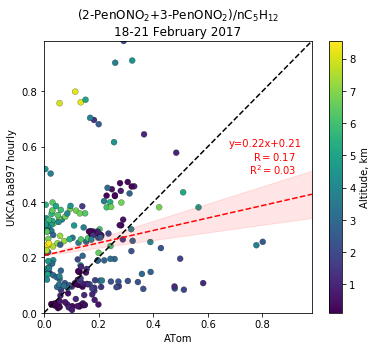

In [24]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_npeono2_nc5h12, traj_npeono2_nc5h12.data, c=atom_dsmms.G_ALT, edgecolors='k', linewidth=0.2)
ax.plot([0,lreg_c5n_x_max], [0,lreg_c5n_x_max], color='k', linestyle='--') # 'one-to-one' line
ax.plot([0,lreg_c5n_x_max], [intrcpt_c5n,lreg_c5n_y_max], color='r', linestyle='--'); # linear regression
ax.fill_between([0,lreg_c5n_x_max], [intrcpt_c5n,lreg_c5n_y_max_minus_std_err], [intrcpt_c5n,lreg_c5n_y_max_plus_std_err], color='r', alpha=0.1)
ax.text(0.675, 0.60, f'y={slope_c5n:1.2f}x+{intrcpt_c5n:1.2f}', color='r') # linear regression equation
ax.text(0.765, 0.55, f'$R=${r_val_c5n:1.2f}', color='r') # correlation coefficient
ax.text(0.75, 0.50, f'$R^2=${r_val_c5n**2:1.2f}', color='r') # r**2 value
# ax.text(0.665, 0.38, f'$p=${p_val_c5n:1.2f}', color='r') # p value
ax.set_title(f'({str_n2peono2}+{str_n3peono2})/{str_nc5h12}\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0,lreg_c5n_x_max)
ax.set_ylim(0,lreg_c5n_x_max)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_RH_C5n.png', bbox_inches='tight')

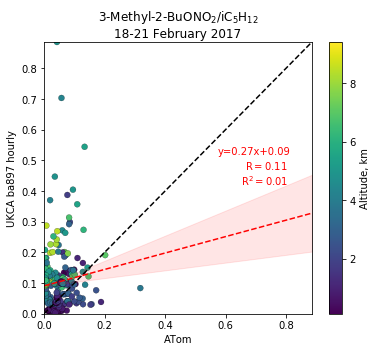

In [25]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_ipeono2_ic5h12, traj_ipeono2_ic5h12.data, c=atom_dsmms.G_ALT, edgecolors='k', linewidth=0.2)
ax.plot([0,lreg_c5i_x_max], [0,lreg_c5i_x_max], color='k', linestyle='--') # 'one-to-one' line
ax.plot([0,lreg_c5i_x_max], [intrcpt_c5i,lreg_c5i_y_max], color='r', linestyle='--'); # linear regression
ax.fill_between([0,lreg_c5i_x_max], [intrcpt_c5i,lreg_c5i_y_max_minus_std_err], [intrcpt_c5i,lreg_c5i_y_max_plus_std_err], color='r', alpha=0.1)
ax.text(0.575, 0.52, f'y={slope_c5i:1.2f}x+{intrcpt_c5i:1.2f}', color='r') # linear regression equation
ax.text(0.665, 0.47, f'$R=${r_val_c5i:1.2f}', color='r') # correlation coefficient
ax.text(0.65, 0.42, f'$R^2=${r_val_c5i**2:1.2f}', color='r') # r**2 value
# ax.text(0.665, 0.38, f'$p=${p_val_c5i:1.2f}', color='r') # p value
ax.set_title(f'{str_ipeono2}/{str_ic5h12}\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} hourly')
ax.set_xlim(0,lreg_c5i_x_max)
ax.set_ylim(0,lreg_c5i_x_max)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_RH_C5i.png', bbox_inches='tight')